In [4]:
import abtem
import dask
import matplotlib.pyplot as plt
import numpy as np
from ase.build import bulk
from ase.cluster import Decahedron
from dask.distributed import Client

In [5]:
import time
import dask
from dask import delayed


In [6]:
abtem.config.set({"device": "gpu"})

abtem.config.set({"fft": "mkl"})
abtem.config.set({"mkl.threads": 1})

dask.config.set({"distributed.scheduler.worker-saturation": 1.0})

In [20]:
client = Client(n_workers=1, threads_per_worker=1)

In [21]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 31.93 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:60725,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 31.93 GiB
Comm: tcp://127.0.0.1:60737,Total threads: 1
Dashboard: http://127.0.0.1:60738/status,Memory: 31.93 GiB
Nanny: tcp://127.0.0.1:60728,


In [7]:
atoms = Decahedron("Au", 10, 2, 0)
atoms.rotate("x", -30)
atoms.center(vacuum=2)

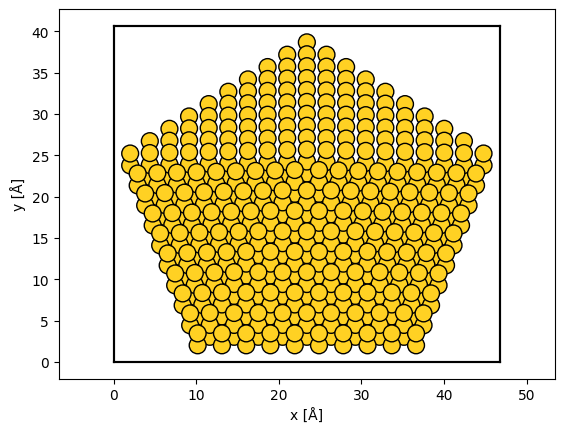

In [8]:
abtem.show_atoms(atoms);

In [9]:
from ase import Atoms
import numpy as np


def import_prismatic_xyz(filename):
    with open(filename) as f:
        lines = f.readlines()
        cell = list(map(float, lines[1].split()))
        positions = []
        numbers = []
        for line in lines[2:-1]:
            line = line.split()
            numbers.append(int(line[0]))
            positions.append(list(map(float, line[1:4])))

    return Atoms(positions=np.array(positions), numbers=numbers, cell=cell)


def export_prismatic_xyz(filename, atoms):
    with open(filename, 'w') as f:
        f.write('test \n')
        f.write('    {} {} {} \n'.format(*np.diag(atoms.cell)))
        for number, position in zip(atoms.numbers, atoms.positions):
            f.write('{}  {}  {}  {}  {}  {} \n'.format(number, *position, 1, 0.00))
        f.write('-1 \n')

        
export_prismatic_xyz("test.xyz", atoms)

In [11]:
import h5py

In [12]:
f = h5py.File('prismatic_output.h5', 'r')

for key, value in f["4DSTEM_simulation"]["data"].items():
    print(value)

<HDF5 group "/4DSTEM_simulation/data/counted_datacubes" (0 members)>
<HDF5 group "/4DSTEM_simulation/data/datacubes" (0 members)>
<HDF5 group "/4DSTEM_simulation/data/diffractionslices" (0 members)>
<HDF5 group "/4DSTEM_simulation/data/pointlistarrays" (0 members)>
<HDF5 group "/4DSTEM_simulation/data/pointlists" (0 members)>
<HDF5 group "/4DSTEM_simulation/data/realslices" (1 members)>
<HDF5 group "/4DSTEM_simulation/data/supergroups" (0 members)>


In [43]:
f.close()

In [13]:
data[0,0].sum()

NameError: name 'data' is not defined

In [14]:
measurement.array[0,0].sum()

NameError: name 'measurement' is not defined

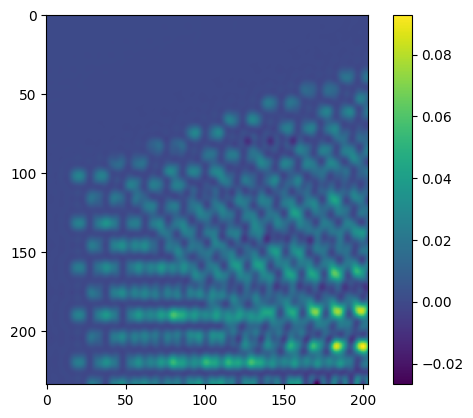

In [31]:
data = f["4DSTEM_simulation"]["data"]["realslices"]["virtual_detector_depth0000"]["data"][:]

prismatic = data[:,:,50:150].sum(-1)
abtem_image = measurement.array[:,:,50:150,0].sum(-1)

prismatic = prismatic / prismatic.max()
abtem_image = abtem_image / abtem_image.max()

plt.imshow(prismatic - abtem_image)
plt.colorbar()

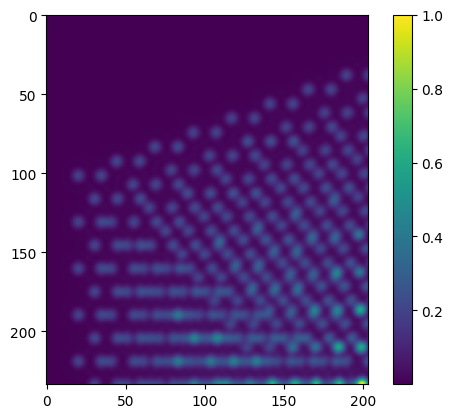

In [32]:
plt.imshow(abtem_image)
plt.colorbar()

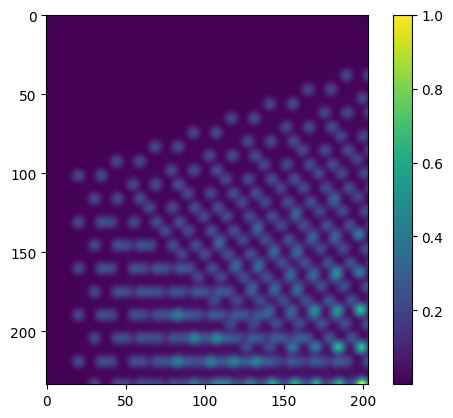

In [30]:
plt.imshow(prismatic)
plt.colorbar()

(0.0, 50.0)

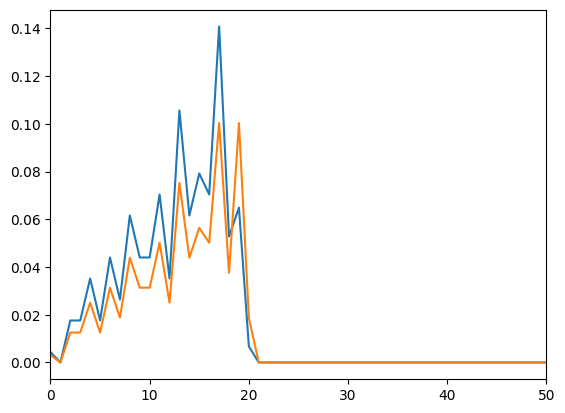

2022-12-05 07:29:54,122 - distributed.scheduler - WARNING - Worker failed to heartbeat within 300 seconds. Closing: <WorkerState 'tcp://127.0.0.1:60737', name: 0, status: running, memory: 0, processing: 0>
2022-12-05 07:29:54,359 - distributed.scheduler - WARNING - Received heartbeat from unregistered worker 'tcp://127.0.0.1:60737'.
2022-12-05 07:30:12,645 - distributed.nanny - WARNING - Worker process still alive after 3.199996795654297 seconds, killing
2022-12-05 07:30:13,401 - distributed.nanny - ERROR - Error in Nanny killing Worker subprocess
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask\lib\asyncio\tasks.py", line 456, in wait_for
    return fut.result()
asyncio.exceptions.CancelledError

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask\lib\site-packages\distributed\nanny.py", line 603, in close
    await self.kill(timeout=timeout, reason=

In [33]:
plt.plot(data[0,0])
plt.plot(measurement.array[0,0])
plt.xlim([0,50])

In [157]:
prismatic.shape

(234, 204)

In [22]:
frozen_phonons = abtem.FrozenPhonons(atoms, 1, {"C": 0.0, "Au": 0.}, ensemble_mean=True)

reverse = atoms.copy()

reverse.positions[:,2] = reverse.cell[2,2] - reverse.positions[:,2]

potential = abtem.Potential(
    reverse,
    gpts=(1200,1200),
    projection="finite",
    slice_thickness=.5,
)

s_matrix = abtem.SMatrix(
    potential=potential, 
    energy=200e3, 
    planewave_cutoff=23,
    interpolation=4, 
    store_on_host=True,
    downsample=False,
)
#s_matrix = s_matrix.build()

scan = abtem.GridScan(start=(0,0), sampling=(.1,.1), end=(.1*234, .1*204), endpoint=False)

#scan.match_probe(s_matrix)


#detector = abtem.AnnularDetector(inner=50, outer=80, to_cpu=False)
detector = abtem.FlexibleAnnularDetector()

#s_matrix.build().array

ctf = abtem.CTF(semiangle_cutoff=21, taper=1, energy=s_matrix.energy)


measurement = s_matrix.scan(scan=scan, detectors=detector, ctf=ctf)


#s_matrix.build()._validate_max_batch_reduction(scan)
#np.prod(measurement.array.shape[:2])

(0, 116, 117, 1, 0, 0) 234 234


In [18]:
scan.gpts

(234, 204)

In [118]:
#scan.get_positions()

In [23]:
%%time
measurement.compute()

CPU times: total: 469 ms
Wall time: 55.4 s


In [20]:
# 512: 68 s, 120 s, 32, 4
# 1024: 206 s, 240 s, 32, 4
# 2048: 101 s, 540 s, 4, 4
# 4096: 65 s, , 1, 4


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

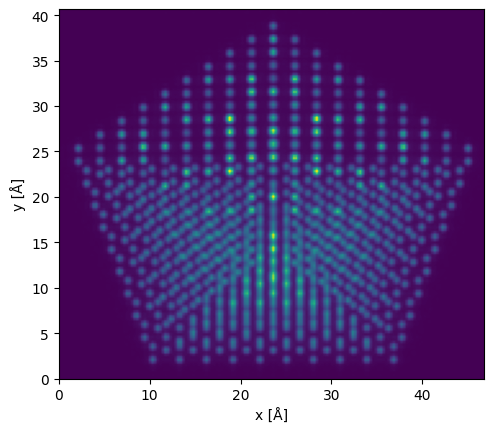

In [16]:
measurement.show()

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

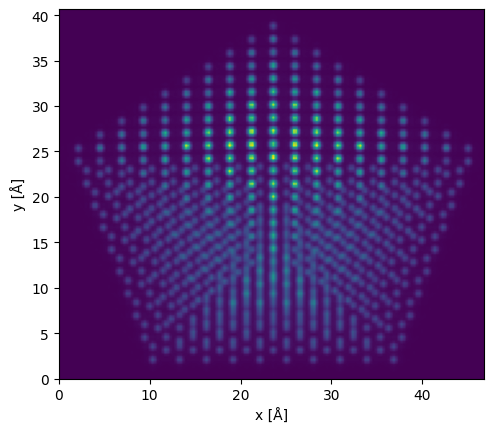

In [14]:
measurement.show()

In [9]:
measurements = s_matrix.build()
measurements.compute(progress_bar=False)
#measurements.diffraction_patterns().sum()

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

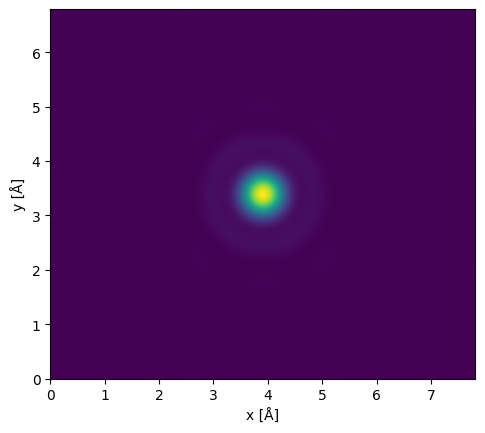

In [34]:
measurements.show()

In [89]:
s_matrix = abtem.SMatrix(
    potential=None, 
    extent=10,
    gpts=401,
    energy=200e3, 
    planewave_cutoff=20, 
    interpolation=4, 
    store_on_host=False,
    downsample=True,
)

[########################################] | 100% Completed | 110.06 ms


array(1.0249456, dtype=float32)

[####                                    ] | 10% Completed | 107.34 ms

C:\Users\jacob\PycharmProjects\abTEM_dask\abtem\prism\s_matrix.py:963: UserWarning: The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.
  warnings.warn(
C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\cupy\fft\_fft.py:454: UserWarning: cuFFT plan cache is disabled on CUDA 11.1 due to a known bug, so performance may be degraded. The bug is fixed on CUDA 11.2+.
  cache = get_plan_cache()


[########################################] | 100% Completed | 1.85 sms


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

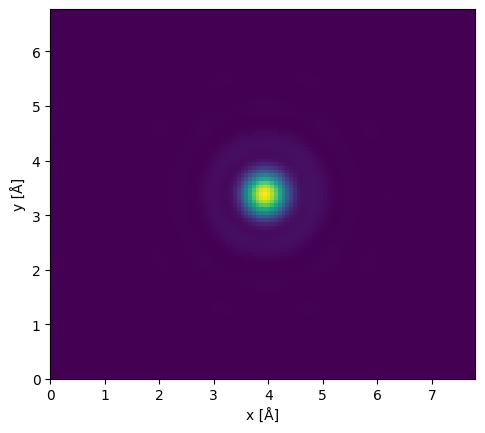

In [28]:
blocks.show()

In [271]:
for i in np.ndindex(blocks.shape):
    if isinstance(blocks[i], int):
        blocks[i] = da.zeros((0, 0), dtype=np.complex64)
    


In [272]:
blocks

array([[dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<_lazy_reduce, shape=(1, 1), dtype=complex64, chunksize=(1, 1), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0), dtype=complex64, chunksize=(0, 0), chunktype=numpy.ndarray>,
        dask.array<zeros_like, shape=(0, 0),

In [290]:
da.block(blocks.tolist())

AttributeError: 'tuple' object has no attribute 'tolist'

In [259]:
da.block(blocks.tolist()).compute()

TypeError: must be real number, not tuple

In [223]:
blocks

array([[1, 1, 1, 1,
        dask.array<_lazy_reduce, shape=(1, 1), dtype=complex64, chunksize=(1, 1), chunktype=numpy.ndarray>,
        1, 1, 1]], dtype=object)

In [191]:
%%time

#with dask.config.set({"optimization.fuse.active": True}):
measurement.compute(num_workers=1)
    #measurement[0].array.compute()

#measurement = measurement.map_blocks(f2, dtype=object)

#measurement[0].compute()

#measurement[0].array

#measurement = measurement.compute()

#Ewith dask.config.set({"optimization.fuse.active": False}):
#    measurement.compute()


[########################################] | 100% Completed | 1.87 sms
CPU times: total: 859 ms
Wall time: 1.89 s


(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

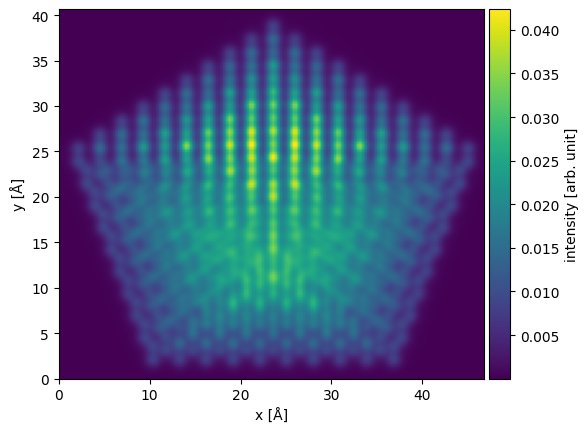

In [194]:
measurement.gaussian_filter(.5).show(cbar=True)

In [11]:
arr

array([[1.46229955e-11, 1.39049310e-11, 1.25275693e-11, ...,
        1.38288868e-11, 1.44112821e-11, 1.51095941e-11],
       [1.44447275e-11, 1.73809647e-11, 2.08285368e-11, ...,
        2.01178501e-11, 1.90718830e-11, 1.81717558e-11],
       [2.40511760e-11, 2.33008838e-11, 1.94022420e-11, ...,
        1.78373965e-11, 2.18509377e-11, 2.42612198e-11],
       ...,
       [3.93119877e-11, 2.78779031e-11, 2.36101399e-11, ...,
        3.19069528e-11, 3.83651548e-11, 4.51331299e-11],
       [2.83184257e-11, 2.23469195e-11, 2.16671091e-11, ...,
        2.02115824e-11, 2.31107009e-11, 2.62643761e-11],
       [1.65680455e-11, 1.47447176e-11, 1.51986167e-11, ...,
        1.50121617e-11, 1.46567411e-11, 1.74007666e-11]], dtype=float32)

In [12]:
measurement[0].show(cbar=True, figsize=(12,12))

[#                                       ] | 2% Completed | 877.96 ms


OutOfMemoryError: Out of memory allocating 716,800,000 bytes (allocated so far: 11,197,019,136 bytes).

(<Figure size 800x800 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

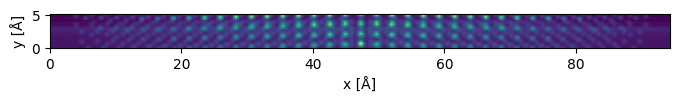

In [60]:
measurement[0,0,6][0].show(figsize=(8,8))

In [47]:
measurement[0,0,0]

dask.array<getitem, shape=(), dtype=object, chunksize=(), chunktype=numpy.ndarray>

In [42]:
measurement

dask.array<f2, shape=(1, 1, 15), dtype=object, chunksize=(1, 1, 1), chunktype=numpy.ndarray>

In [20]:
def f(a):
    return a.sum(1)

#array = s_matrix.build().array

array = s_matrix.build().rechunk_planewaves((1,10)).array
#array = array.rechunk((1,-1,-1,256))

array = array.map_overlap(f, depth={0:0,1:0,2:0,3:116}, trim=False, boundary="periodic", drop_axis=1)

array

array.compute()

array([[[0.00020506-0.00097659j, 0.00020619-0.00097285j,
         0.00020967-0.00096088j, ..., 0.00021419-0.00093934j,
         0.00020905-0.00095948j, 0.00020606-0.00097202j],
        [0.00020652-0.00097319j, 0.00020807-0.00096941j,
         0.00021172-0.00095777j, ..., 0.00021609-0.00093641j,
         0.00021068-0.0009568j , 0.00020737-0.00096906j],
        [0.00021061-0.00096205j, 0.00021182-0.00095829j,
         0.00021535-0.00094635j, ..., 0.00021936-0.00092538j,
         0.00021434-0.0009453j , 0.00021147-0.00095762j],
        ...,
        [0.00021327-0.00093722j, 0.00021448-0.00093359j,
         0.0002178 -0.0009222j , ..., 0.00022306-0.00090082j,
         0.00021769-0.00092081j, 0.00021435-0.00093299j],
        [0.00020844-0.00095838j, 0.00020949-0.00095474j,
         0.00021283-0.00094296j, ..., 0.00021783-0.00092142j,
         0.00021261-0.00094144j, 0.00020951-0.00095386j],
        [0.00020543-0.00097135j, 0.00020687-0.00096763j,
         0.00021042-0.00095604j, ..., 0.00021

In [ ]:
def f(i):
    time.sleep(.2)
    return np.zeros((1,1,4))

def f2(a):
    time.sleep(.2)
    return a

a = []
for i in range(12):
    #with dask.annotate(priority=-i - 1): 
    a.append(da.from_delayed(dask.delayed(f)(i), shape=(1,1,4), dtype=float))
    #a.append(da.from_delayed(dask.delayed(f)(i), shape=(1,1,4), dtype=float))

a = da.concatenate(a)

a = a.rechunk((1,1,1))

b = a[..., :2]
c = a[..., 2:]

a = da.concatenate([b, c], axis=-1)

#a = a.map_blocks(f2, meta=np.array((), dtype=float))

a = a.sum(0, split_every=2)

#dask.visualize(a, optimize_graph=False)
#dask.visualize(a, color="order", optimize_graph=False)

dask.compute(a, optimize_graph=False)

In [30]:
array = s_matrix.build().array

array = array.rechunk((1,-1,-1,128))

def f(b):
    return b.sum(axis=1)

blocks = []
for i in range(1, 18):
    block = array.blocks[:,:,:,i-1:i+2].rechunk((1,-1,-1,-1))
    block = block.map_blocks(f, drop_axis=1, dtype=float)    
    blocks.append(block)

blocks = da.concatenate(blocks, axis=-1)
    
blocks.compute()



array([[[0.00020506-0.00097659j, 0.00020619-0.00097285j,
         0.00020967-0.00096088j, ..., 0.00021419-0.00093934j,
         0.00020905-0.00095948j, 0.00020606-0.00097202j],
        [0.00020652-0.00097319j, 0.00020807-0.00096941j,
         0.00021172-0.00095777j, ..., 0.00021609-0.00093641j,
         0.00021068-0.0009568j , 0.00020737-0.00096906j],
        [0.00021061-0.00096205j, 0.00021182-0.00095829j,
         0.00021535-0.00094635j, ..., 0.00021936-0.00092538j,
         0.00021434-0.0009453j , 0.00021147-0.00095762j],
        ...,
        [0.00021327-0.00093722j, 0.00021448-0.00093359j,
         0.0002178 -0.0009222j , ..., 0.00022306-0.00090082j,
         0.00021769-0.00092081j, 0.00021435-0.00093299j],
        [0.00020844-0.00095838j, 0.00020949-0.00095474j,
         0.00021283-0.00094296j, ..., 0.00021783-0.00092142j,
         0.00021261-0.00094144j, 0.00020951-0.00095386j],
        [0.00020543-0.00097135j, 0.00020687-0.00096763j,
         0.00021042-0.00095604j, ..., 0.00021

In [ ]:
#b = array.sum(2)

#array = array.rechunk((-1,-1,-1,160))

#c = array.sum(2)

#d = da.concatenate([b,c])

#d.compute()

#chunks = (100000,260)

#a = s_matrix.build().rechunk_planewaves(chunks).array #".sum(1).compute()



In [59]:
import dask.array as da

frozen_phonons = abtem.FrozenPhonons(atoms, 1, {"C": 0.0, "Au": 0.0}, ensemble_mean=True)

potential = abtem.Potential(
    frozen_phonons,
    gpts=4096,
    projection="infinite",
    slice_thickness=1000,
)

s_matrix = abtem.SMatrix(
    potential=potential, energy=200e3, planewave_cutoff=20, interpolation=10, store_on_host=True,
)

#s_matrix = s_matrix.build()

scan = abtem.GridScan(sampling=10)

#a = s_matrix.build().array.rechunk((1,-1, 256, 256))#.sum(1).compute()

chunks = s_matrix.build()._validate_rechunk_scheme(rechunk_scheme="interpolation")

chunks = (100000,256)

a = s_matrix.build().rechunk_planewaves(chunks).array#".sum(1).compute()

def f(a):
    return a.sum(1)

a = a.map_overlap(f, depth={0:0,1:0,2:0,3:0}, trim=True, boundary="periodic", drop_axis=1)
#s_matrix.build()._overlap_depth()
#a = s_matrix.scan(scan=scan, max_batch_reduction=1, rechunk_scheme=(1,20))


a.compute()




#a = a.compute()

#measurement = s_matrix.scan(rechunk_scheme=(10,10), scan=scan)

#dask.config.set({"distributed.scheduler.worker-saturation": 1.0})
#measurement.compute()

C:\Users\jacob\PycharmProjects\abTEM_dask\abtem\prism\s_matrix.py:991: UserWarning: The interpolation factor does not exactly divide 'gpts', normalization may not be exactly preserved.
  warnings.warn(


RuntimeError: num_chunks may not be larger than num_items

In [ ]:
da.ones((1000,1000)).sum()

In [9]:
chunks

((273, 273, 273, 273, 273, 273, 273, 273, 273, 273),
 (232, 232, 232, 232, 232, 232, 232, 232, 232, 232))

In [27]:
s_matrix.build().array

dask.array<wrapped_build_s_matrix, shape=(1, 151, 2730, 2320), dtype=complex64, chunksize=(1, 3, 2730, 2320), chunktype=cupy.ndarray>

(<Figure size 640x480 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

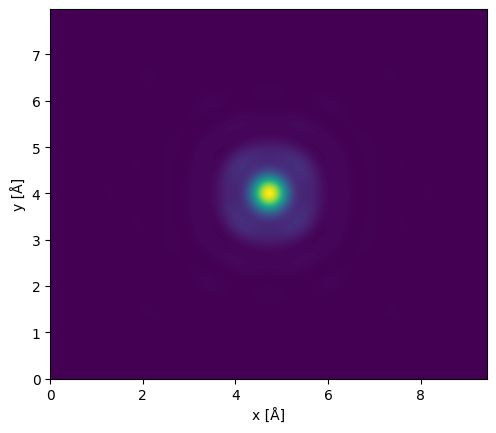

In [18]:
dummy_probes = s_matrix.dummy_probes()

dummy_probes.aberrations.defocus = -potential.thickness

dummy_probes.show()

(<Figure size 1200x1200 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

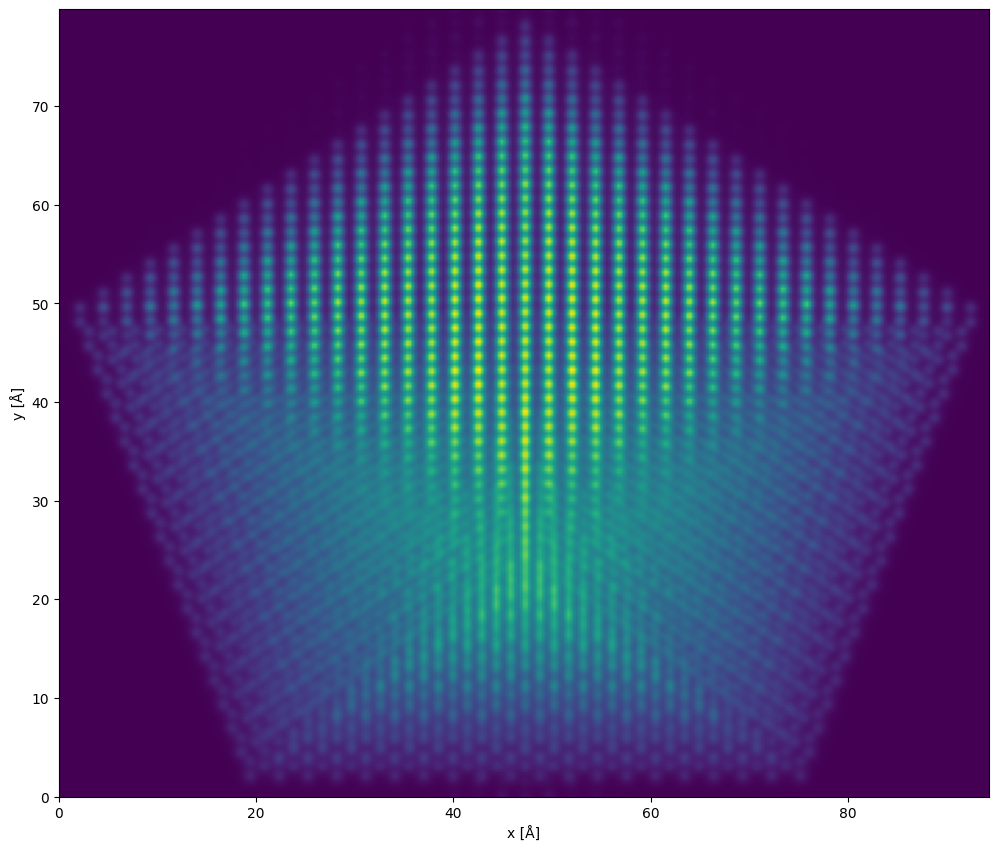

In [22]:
measurement.integrate_radial(50, 120).gaussian_filter(.35).show(figsize=(12,12))

In [10]:
import gc

def compute(s_matrix):
    array = s_matrix.reduce()
    #array = array.persist()
    
    c = array.sum(1, split_every=2)
    
    c.persist()
    
    d = c.sum(0, split_every=2)
    
    #del array
    
    return d.compute()


compute(s_matrix)

2022-11-04 09:44:45,440 - distributed.scheduler - ERROR - Error transitioning 'Atoms-2529ab67-958d-4f98-ba96-9d8b20470a9b' from 'queued' to 'memory'
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\scheduler.py", line 1598, in _transition
    assert not args and not kwargs, (args, kwargs, start, finish)
AssertionError: ((), {'worker': 'tcp://127.0.0.1:56414', 'nbytes': 48, 'type': b'\x80\x04\x95\x17\x00\x00\x00\x00\x00\x00\x00\x8c\tase.atoms\x94\x8c\x05Atoms\x94\x93\x94.', 'typename': 'ase.atoms.Atoms', 'metadata': {}, 'thread': 4296, 'startstops': ({'action': 'compute', 'start': 1667551485.35944, 'stop': 1667551485.359449},), 'status': 'OK'}, 'queued', 'memory')
2022-11-04 09:44:45,444 - distributed.core - ERROR - ((), {'worker': 'tcp://127.0.0.1:56414', 'nbytes': 48, 'type': b'\x80\x04\x95\x17\x00\x00\x00\x00\x00\x00\x00\x8c\tase.atoms\x94\x8c\x05Atoms\x94\x93\x94.', 'typename': 'ase.atoms.Atoms', 'metadata': {}, 't

KeyboardInterrupt: 

Task exception was never retrieved
future: <Task finished name='Task-12418' coro=<Client._gather.<locals>.wait() done, defined at C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-12432' coro=<Client._gather.<locals>.wait() done, defined at C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\client.py:2054> exception=AllExit()>
Traceback (most recent call last):
  File "C:\Users\jacob\anaconda3\envs\abtem-dask-gpu\lib\site-packages\distributed\client.py", line 2063, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-12443' coro=<Client._gather.<locals>.wait() done, defin

In [14]:
array

NameError: name 'array' is not defined

In [11]:
del array

(<Figure size 1200x1200 with 2 Axes>, <Axes: xlabel='x [Å]', ylabel='y [Å]'>)

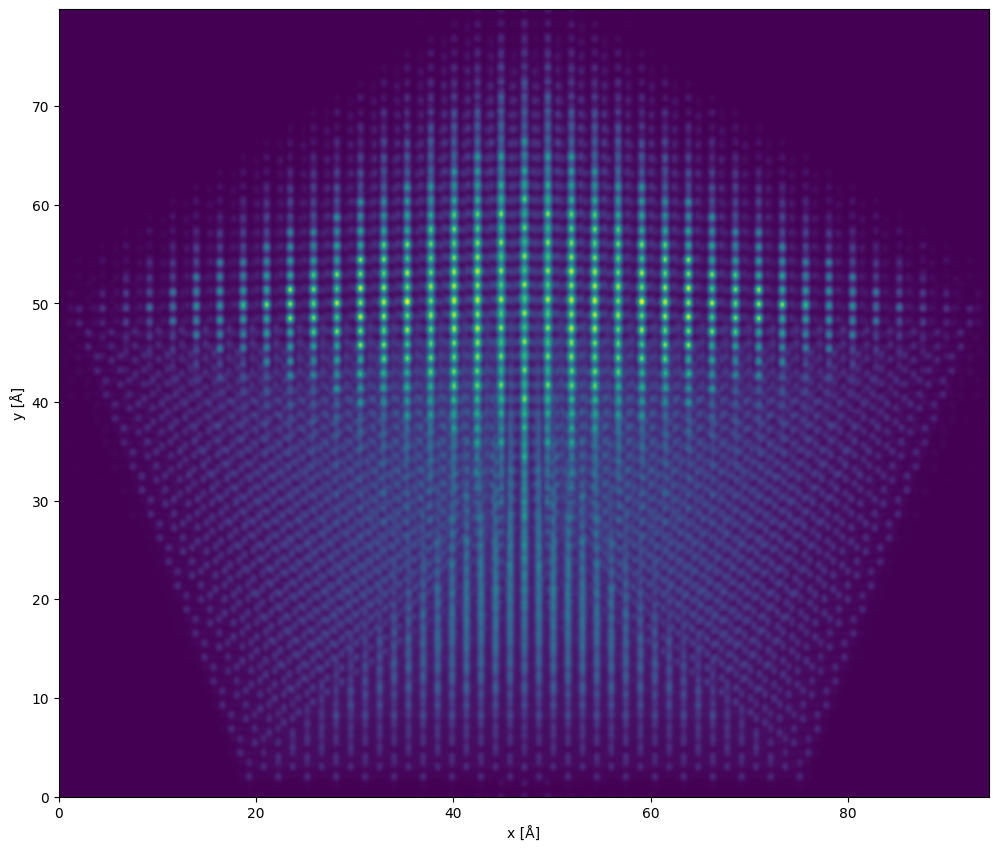

In [13]:
measurement.integrate_radial(50, 150).interpolate(.1).show(figsize=(12,12))